In [1]:
from model import UNet
from utils import *
from data import mask_dataset
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from glob import glob
import torch
import torch.nn as nn
sampleRate = 68.27

In [4]:
# Copy these parameters from the main script so that the loaded model has the same hidden layers.
N_sub = 32
batch_size = 56
hidden_layers = 12
learning_rate = 0.01
num_epochs = 10

## Load Test Data

In [5]:
test_path = "test"
test_files = glob(os.path.join(test_path, '*.npy'))
test_dataset = mask_dataset(data_path='test', f_min = 1, f_max = 10, N_sub=N_sub, sampleRate=sampleRate)
test_loader = DataLoader(test_dataset,batch_size = batch_size,drop_last=True,shuffle = False)

In [33]:
criterion = nn.MSELoss()

## Load Trained Model

In [7]:
model = UNet(input_bands=1, output_classes=1,hidden_channels=hidden_layers)
state = torch.load('model.pth')
model.load_state_dict(state['model_state_dict'])
model.eval();


## Get Reconstructions

In [8]:
losses = []
evals = []
outputs = []
for i,(eval_samples, masks) in tqdm(enumerate(test_loader)):
    samples = eval_samples*masks.clone().detach()
    samples = torch.unsqueeze(samples.squeeze(), 1)
    output = model(samples)
    loss = criterion(eval_samples.squeeze(), output.squeeze()).item()
    print(f"Loss is: {loss}")
    losses.append(loss)
    evals.append(eval_samples.squeeze())
    outputs.append(output.detach().squeeze())

1it [00:02,  2.37s/it]

Loss is: 0.004061480518430471


2it [00:05,  2.56s/it]

Loss is: 0.003004981903359294


3it [00:07,  2.68s/it]

Loss is: 0.008765741251409054


4it [00:10,  2.67s/it]

Loss is: 0.007944443263113499


5it [00:13,  2.71s/it]

Loss is: 0.004264590796083212


6it [00:16,  2.73s/it]

Loss is: 0.004314082209020853


7it [00:19,  2.80s/it]

Loss is: 0.002405503299087286


8it [00:21,  2.67s/it]

Loss is: 0.0034859911538660526


9it [00:23,  2.58s/it]

Loss is: 0.0015543519984930754


10it [00:26,  2.55s/it]

Loss is: 0.001035682624205947


11it [00:28,  2.48s/it]

Loss is: 0.0014961017295718193


12it [00:31,  2.49s/it]

Loss is: 0.0027936676051467657


13it [00:33,  2.49s/it]

Loss is: 0.003393762046471238


14it [00:36,  2.59s/it]

Loss is: 0.006719914730638266


15it [00:38,  2.55s/it]

Loss is: 0.0034171727020293474


16it [00:41,  2.55s/it]

Loss is: 0.004906973335891962


17it [00:44,  2.57s/it]

Loss is: 0.0031439177691936493


18it [00:46,  2.62s/it]

Loss is: 0.00406487425789237


19it [00:49,  2.66s/it]

Loss is: 0.004615976475179195


20it [00:52,  2.68s/it]

Loss is: 0.003435896011069417


21it [00:54,  2.69s/it]

Loss is: 0.002927506575360894


22it [00:57,  2.61s/it]

Loss is: 0.002863788977265358


23it [00:59,  2.52s/it]

Loss is: 0.0012645492097362876


24it [01:02,  2.56s/it]

Loss is: 0.0030281837098300457


25it [01:05,  2.60s/it]

Loss is: 0.003388594137504697


26it [01:07,  2.58s/it]

Loss is: 0.002996529685333371


27it [01:10,  2.60s/it]

Loss is: 0.005181206855922937


28it [01:12,  2.55s/it]

Loss is: 0.0032593936193734407


29it [01:15,  2.58s/it]

Loss is: 0.00530241010710597


30it [01:17,  2.58s/it]

Loss is: 0.004755561705678701


31it [01:20,  2.55s/it]

Loss is: 0.004625073634088039


32it [01:22,  2.59s/it]

Loss is: 0.003645953955128789


In [50]:
min_loss = np.argmin(losses)
outputs_ = [taper_filter(i,1,10,sampleRate) for i in outputs]

In [51]:
batch_idx = min_loss # select batch with min loss
event = 15 # select one of 56 events 
channel = 16 #if you want to do a line plot, pick channel

I chose channel 16 as it is the one that's more frequently targeted and blanked out (it's the center one),  
 so that's the most interesting channel to pick to see how the reconstruction is done.

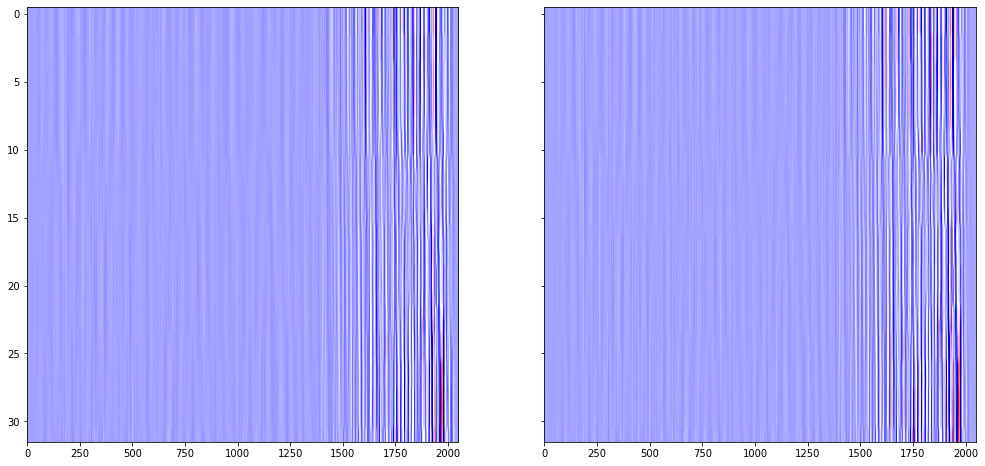

In [52]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(17,8),sharex = True, sharey = True)
pl1 = ax1.imshow(evals[batch_idx][event],aspect = 'auto',cmap = 'seismic')
pl2 = ax2.imshow(outputs_[batch_idx][event],aspect = 'auto',cmap = 'seismic')
# cbar = fig.colorbar(pl1, ax=ax2, shrink=0.95)


## Wiggle for wiggle comparison

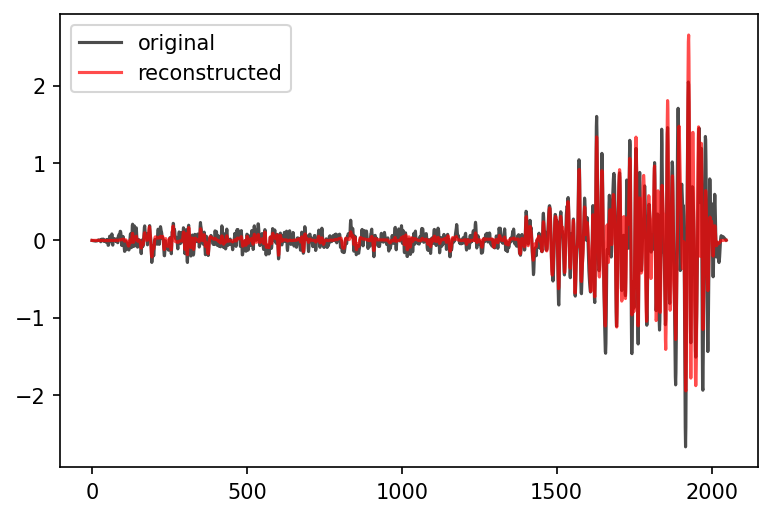

In [60]:
plt.figure(dpi=150)
plt.plot(evals[batch_idx][event, channel],alpha=0.7,label='original',color='black')
plt.plot(outputs_[batch_idx][event, channel],alpha=0.7,label='reconstructed',color='red')
plt.legend()

In [63]:
# plt.plot(compute_moving_coherence(outputs_[batch_idx][event,channel],16))
# plt.axhline(y=1)

This screenshot is from the original paper, so we're close but we have a long way to go.

![Reference](./reference.png)

I need an implementation of a different `test loader` that doesn't mask the input, as we don't need that for inference.  
A simple test loader that segments the input 'image' into pieces so that it can be put through the neural network is enough.